### Predgovor
Ova vježba sastoji se od teoretskog i praktičnog dijela. Bez adekvatnog teorijskog razumijevanja, implementacijska izvedba će biti začajno izazovnija. 

Predlažemo da napravite kopiju ove bilježnice na svoj Colab profil i tamo riješite vježbu. Ne zaboravite uključiti GPU akceleraciju (Runtime->Change runtime type->GPU->Save). Teorijske izvode i dokaze možete napraviti i na papiru kojeg je onda potrebno ponijeti na predaju vježbe.

U slučaju nejasnoća javite se na matej.grcic@fer.hr.

# 4. Laboratorijska vježba - generativno modeliranje

Jedan od glavnih katalizatora u razvoju modernog računalnog vida jest dostupnost velikih skupova podataka. Iako su skupovi podataka lako dostupni, proces koji generira podatke je često nepoznat. Cilj ove laboratorijske vježbe jest pokušati aproksimirati proces koji generira dani skup podataka.


## Teorijska podloga generativnom modeliranju

Krenuti ćemo od bolje definicije zadatka.
Pretpostavimo postojanje skupa podataka $D=\{\mathbf{x}_i\}_{i=1}^N$ koji je nastao uzorkovanjem nepoznate distribucije $P_D(\underline{\mathbf{x}})$. Nadalje, pretpostavimo da je svaki primjer $\mathbf{x}_i$ dobiven nezavisnim uzorkovanjem. Naš cilj je aproksimirati nepoznatu distribuciju podataka $P_D(\underline{\mathbf{x}})$ poznatim modelom $P_\theta(\underline{\mathbf{x}})$.
S obzirom da su naši podaci često u kontinuirani ($\underline{\mathbf{x}}$ je kontinuirana slučajna varijabla) baviti ćemo se modeliranjem gustoća vjerojatnosti $p_D(\underline{\mathbf{x}})$ i $p_\theta(\underline{\mathbf{x}})$.

**Problem 1.:** Kako poravnati nepoznati $p_D(\underline{\mathbf{x}})$ i poznati $p_\theta(\underline{\mathbf{x}})$?



U teoriji vjerojatnosti, različitost između dvije distribucije $P(\underline{x})$ i $Q(\underline{x})$ se mjeri pomoću f-divergencije. Jedna od najčešćih mjera iz obitelji f-divergencija je KL-divergencija. KL-divergenciju za kontinuirane slučajne varijable definiramo kao:
$$
\mathrm{KL}(P, Q) = \int_{-\infty}^{+\infty} p(x) \ln\frac{p(x)}{q(x)} dx.
$$
$p$ i $q$ su pripadajuće gustoće vjerojatnosti.

KL-divergencije između distribucije podataka i distribucije modela je primamljiv gubitak za naš optimizacijski postupak. Može se pokazati da je minimizacija KL divergencije između distribucije podataka i distribucije modela ekvivalentna minimizaciji negativne log-izglednosti skupa podataka za učenje:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) \simeq \underset{\theta}{\mathrm{min}} \, -\mathbb{E}_{\mathbf{x} \in D} \;\;  [\ln p_\theta(\mathbf{x})]
$$

**Zadatak 1.**: Dokažite navedenu tvrdnju.

Dokaz:
\begin{align*}
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) &= \underset{\theta}{\mathrm{min}}  \int_{-\infty}^{+\infty} \ln \frac{p_D(x)}{p_\theta(x)} \cdot p_D(x) dx \\
&= \underset{\theta}{\mathrm{min}} \:\:  \mathbb{E}_{\mathbf{x} \in D} \ln \frac{p_D(x)}{p_\theta(x)} \\
&= \underset{\theta}{\mathrm{min}} \:\:  \mathbb{E}_{\mathbf{x} \in D} [\ln p_D(x) - \ln p_\theta(x)] \\
&= \underset{\theta}{\mathrm{min}} \:\:  \mathbb{E}_{\mathbf{x} \in D} [-\ln p_\theta(x)] \\
&= \underset{\theta}{\mathrm{min}} \:\:  - \mathbb{E}_{\mathbf{x} \in D} [\ln p_\theta(x)] \\
\end{align*}


**Problem 2.**: Definicija modela $p_\theta$.

Naš sljedeći korak je definirati model $p_\theta$. Upravo po definiciji  $p_\theta$ razlikujemo različite generativne modele.
Na primjer autoregresivna faktorizacija modela dovodi do autoregresijskih modela, dok modeliranje nenormalizirane distribucije dovodi do energijskih modela. U ovoj vježbi se fokusiramo  na vrstu generativnih modela koje nazivamo normalizirajući tokovi. Normalizirajući tok $p_\theta$ definiramo pomoću formule za zamjenu varijabli distribucije.

Pretpostavimo da su $\underline{\mathbf{x}}$ i $\underline{\mathbf{z}}$ dvije kontinuirane slučajne varijable. Pretpostavimo da bijekcija $f$ mapira realizacije slučajne varijable $\underline{\mathbf{x}}$ u realizacije od $\underline{\mathbf{z}}$, to jest $\mathbf{z} = f(\mathbf{x})$. S obzirom da je $f$ bijekcija vrijedi i obrat $\mathbf{x} = f^{-1}(\mathbf{z})$. Formulu za zamjenu varijabi distribucije definiramo kao:
$$
 p(\mathbf{x}) = q(\mathbf{z}) \left| \mathrm{det} \frac{\partial \mathbf{z}}{ \partial \mathbf{x}} \right|, \quad \mathbf{z} = f(\mathbf{x})
$$
$\frac{∂ \mathbf{z}}{ ∂ \mathbf{x}}$ predstavlja Jakobijan funkcije $f$ za $\textbf{x}$. det predstavlja determinantu. $|\cdot|$ predstavlja apsolutnu vrijednost.
To jest, drugi član umnoška odgovara apsolutnoj vrijednosti determinante Jakobijana transformacije $f$.

Formulu za zamjenu varijabli ćemo iskoristiti za izgradnju okvira koji nam omogućava implementaciju dubokog generativnog modela.
Ideja je jednostavna, distribuciju $q(\mathbf{z})$ možemo predefinirati (npr. kao Gaussovu distribuciju). Tada nam je jedina nepoznanica bijekcija $f$ koju možemo parametrizirati s $\theta$ te naučiti optimizacijskim postupkom.


Prisjetimo se sljedećih teorema:
1. kompozicija bijekcija je bijekcija, tj $f$ možemo raspisati kao $f = f_1 ∘ f_2 ∘ f_3 ∘ \dots \circ f_K$.
2. pravilo ulančavanja: $\frac{∂ z_3}{ ∂ z_1} = \frac{∂ z_3}{ ∂ z_2}\frac{∂ z_2}{ ∂ z_1} $
3. determinanta umnoška dviju kvadratnih matrica istog reda jednaka je umnošku determinanti svake matrice (Binet-Cauchyjev teorem)
4. Apsolutna vrijednost umnoška dva realna broja je jednaka umnošku apsolutnih vrijednosti: $|a\cdot b| = |a|\cdot |b|$

Bijekciju $f$ možemo promatrati kao kompoziciju funkcija, gdje svaka funkcija $f_i$ prima varijablu $z_{i-1}$ i računa varijablu $z_i$. 
Ako uzmemo u obzir prethodno spomenute teoreme, dolazimo do sljedeće formulacije:
$$
 p_\theta (\mathbf{x}) = q(\mathbf{z}_K) \prod_{k=1}^K \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$
gdje je $\mathbf{z}_{0} = \mathbf{x}$.
$q(\mathbf{z}_K)$ može biti proizvoljna distribucija pa je definiramo kao $q(\mathbf{z}_K):= \mathcal{N}(\mathbf{z}_K; 0, \mathrm{I})$.

**Zadatak 2.** Krenuvši od općenite formule za zamjenu varijabli izvedite izraz za normalizirajući tok.

Izvod:
\begin{align*}
p(\mathbf{x}) &= q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f(\mathbf{x})}{ \partial \mathbf{x}} \right| \\ 
&= q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f_K \circ f_{K-1} \circ \dots \circ f_1(\mathbf{x})}{ \partial \mathbf{x}} \right| \\
&= q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f_K}{\partial f_{K-1}} \cdot \dots \cdot \frac{\partial f_1}{\partial \mathbf{x}} \right| \\
&= q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f_K}{\partial f_{K-1}} \cdot \dots \cdot \mathrm{det} \frac{\partial f_1}{\partial \mathbf{x}} \right| \\
&= q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f_K}{\partial f_{K-1}} \right| \cdot \dots \cdot \left| \mathrm{det} \frac{\partial f_1}{\partial \mathbf{x}} \right| \\
&= q(\mathbf{z}_K) \prod_{k=1}^{K} \left| \mathrm{det} \frac{\partial \mathbf{z}_k}{\partial \mathbf{z}_{k-1}} \right|  
\end{align*}

Spomenimo još da nas općenito zanima logaritam gustoće vjerojatnosti pa pišemo:
$$
 \ln p_\theta (\mathbf{x}) = \ln q(\mathbf{z}_K) +\sum_{k=1}^K \ln \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$

Ostala nam je još jedna nepoznanica, a to je dizajn funkcija $f_k$,  $k=1,...,K$.
Dizajn funkcije f ovisi o podacima koje modeliramo. Razmislite kako biste bijekciju modelirali kao gradivni blok dubokog modela.

## Modeliranje 2D skupa podataka normalizirajućim tokom

**Problem 3.** Modeliranje 2D skupa podatka. 

In [1]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as tf
from torch.utils.data import DataLoader, Subset

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

import matplotlib.pyplot as plt

In [2]:
class GaussianMixture2DDataset:
    def __init__(self, num_samples, n_comp=2, loc=torch.zeros(2,2), scale=torch.ones(2,2), pi=(torch.ones(2)/2)):
        samples_per_component = (pi * num_samples).long()
        self.samples = torch.cat([torch.randn(samples_per_component[i],2) * scale[i] + loc[i] for i in range(n_comp)], 0)

    def __getitem__(self, idx):
        return self.samples[idx]

Promotrimo sljedeći skup podataka. Pretpostavimo da nam je dostupan samo skup podataka $D$. Cilj nam je aproksimirati distribuciju podataka $p_D$ pomoću normalizirajućeg toka.

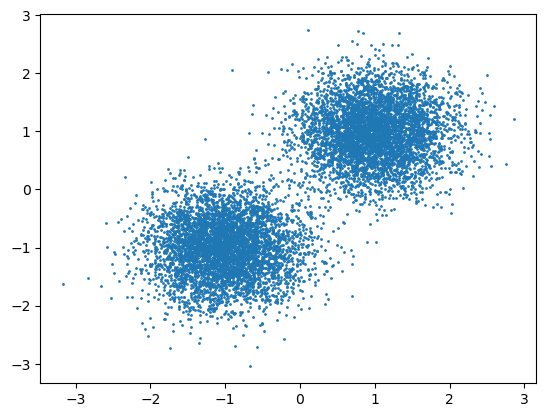

In [3]:
D = GaussianMixture2DDataset(9999, loc=torch.tensor([[-1, -1], [1,1]]), scale=torch.tensor([[0.5, 0.5], [0.5,0.5]])).samples
plt.scatter(D[:, 0], D[:, 1], 1)
plt.show()

S obzirom da modeliramo 2D skup podatka, zanimaju nas funkcije s domenom $\mathbb{R}^2$ i kodomenom $\mathbb{R}^2$ koje imaju inverz.
Definiramo sljedeći implementacijski ovir:

In [4]:
class _Bijection(nn.Module):
    def __init__(self):
        super(_Bijection, self).__init__()

    def forward(self, x):
        pass

    def inverse(self, z):
        pass

    def regularization(self):
        return 0.

Pokušajmo ponuditi bijektivnu alternativu sloju torch.nn.Linear.
1. Unaprijedni prolaz mora vratiti izlaz sloja te logaritam apsolutne vrijednosti determinante Jakobijana
2. inverzni prolaz mora vratiti ulaz u sloj
3. Transformaciju je potrebno držati invertibilnom s regularzacijskim članom



**Zadatak 3.**: Nadopunite forward i inverse funkciju. 

Hint: Linearna transformacija se primjenjuje na svaki primjer u minigrupi nezavisno.

In [5]:
def sum_except_batch(x, num_dims=1):
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

class BijectiveLinear(_Bijection):
    def __init__(self, dim):
        super(_Bijection, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.eye(dim))
        self.bias = nn.Parameter(torch.zeros(1, dim))
    
    def forward(self, x):   # x has shape NxD 
        z = x @ self.weight + self.bias
        log_abs_det = torch.log(torch.abs(torch.det(self.weight)))
        return z, log_abs_det # shapes NxD, N

    def inverse(self, z):
        x = (z - self.bias) @ torch.inverse(self.weight)
        return x    # NxD

    def regularization(self):
        return ((self.weight @ self.weight) - torch.eye(self.dim)).abs().sum()


Normalizirajući tok implementiramo sljedećim kodom. Primjetite da direktno računamo $\ln p_\theta(\mathbf{x})$.

In [6]:
class _NormalizingFlow(nn.Module):
    def __init__(self):
        super(_NormalizingFlow, self).__init__()

    def log_prob(self, x):
        pass

    def forward(self, x):
        pass

    def inverse(self, z):
        pass

    def sample(self, num_samples):
        pass


class SimpleNF(_NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        super(SimpleNF, self).__init__()
        self.transforms = nn.Sequential()
        for _ in range(num_steps):
            self.transforms.append(BijectiveLinear(input_dim))
            
        self.register_buffer('loc', torch.zeros(input_dim))
        self.register_buffer('log_scale', torch.zeros(input_dim))

    def z_dist(self):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        return z_dist

    def log_prob(self, x):
        z = x
        log_abs_det = 0.
        for m in self.transforms:
            z, ld_layer = m(z)
            log_abs_det += ld_layer
        log_pz = self.z_dist().log_prob(z).sum(-1)
        log_px =  + log_pz + log_abs_det
        return log_px

    def gather_regularization(self):
        return sum([m.regularization() for m in self.transforms])
    
    def forward(self, x):
        z = x
        for m in self.transforms:
            z, _ = m(z)
        return z

    def inverse(self, z):
        for m in reversed(self.transforms):
            z = m.inverse(z)
        return z

    def sample(self, num_samples, T=1):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        z = z_dist.sample(torch.Size([num_samples])) * T
        x = self.inverse(z)
        return x

Provjerite svoju implementaciju inverza sljedećim kodom:

In [7]:
flow = SimpleNF(2, num_steps=7)
print((flow.inverse(flow(D)) - D).sum().item())
assert (flow.inverse(flow(D)) - D).sum() < 1e-9

0.0


Tok učimo optmizacijom prethodno objašnjenog gubitka.

In [8]:
flow = SimpleNF(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-1)

for iter in range(4000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    loss_reg = flow.gather_regularization()
    total_loss = loss + 0.001 * loss_reg
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()} Reg:{loss_reg.item()}")

Iter 1: Loss:3.0862061977386475 Reg:0.0
Iter 21: Loss:2.5467262268066406 Reg:3.0695953369140625
Iter 41: Loss:2.574589967727661 Reg:3.1120777130126953
Iter 61: Loss:2.548788547515869 Reg:3.19917631149292
Iter 81: Loss:2.5468056201934814 Reg:3.2019288539886475
Iter 101: Loss:2.54664945602417 Reg:3.198403835296631
Iter 121: Loss:2.546635150909424 Reg:3.1945319175720215
Iter 141: Loss:2.546633005142212 Reg:3.190741777420044
Iter 161: Loss:2.546633243560791 Reg:3.1870620250701904
Iter 181: Loss:2.546632766723633 Reg:3.183497190475464
Iter 201: Loss:2.546633005142212 Reg:3.1800317764282227
Iter 221: Loss:2.546633005142212 Reg:3.176673412322998
Iter 241: Loss:2.546633243560791 Reg:3.1734156608581543
Iter 261: Loss:2.546632766723633 Reg:3.1702523231506348
Iter 281: Loss:2.546632766723633 Reg:3.1671876907348633
Iter 301: Loss:2.546633243560791 Reg:3.1642141342163086
Iter 321: Loss:2.546632766723633 Reg:3.161328077316284
Iter 341: Loss:2.546632766723633 Reg:3.1585307121276855
Iter 361: Loss:2.5

Iter 2921: Loss:2.5470659732818604 Reg:3.0912728309631348
Iter 2941: Loss:2.5470757484436035 Reg:3.0905213356018066
Iter 2961: Loss:2.5470848083496094 Reg:3.089578151702881
Iter 2981: Loss:2.5470924377441406 Reg:3.089684247970581
Iter 3001: Loss:2.547065496444702 Reg:3.0877201557159424
Iter 3021: Loss:2.5470728874206543 Reg:3.0865745544433594
Iter 3041: Loss:2.547064781188965 Reg:3.0854508876800537
Iter 3061: Loss:2.5471017360687256 Reg:3.0846519470214844
Iter 3081: Loss:2.547102689743042 Reg:3.083563804626465
Iter 3101: Loss:2.547072649002075 Reg:3.081883668899536
Iter 3121: Loss:2.5470762252807617 Reg:3.0805654525756836
Iter 3141: Loss:2.547093629837036 Reg:3.079259157180786
Iter 3161: Loss:2.547093152999878 Reg:3.077806234359741
Iter 3181: Loss:2.54707670211792 Reg:3.0760936737060547
Iter 3201: Loss:2.5471088886260986 Reg:3.074855089187622
Iter 3221: Loss:2.5471067428588867 Reg:3.073052406311035
Iter 3241: Loss:2.5471036434173584 Reg:3.070984125137329
Iter 3261: Loss:2.5471374988555

Provjerimo još jednom stabilnost inverza. Kako biste komentrali rezultate?

In [9]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(2.4498e-05, grad_fn=<SumBackward0>)


Generiranje primjera s normalizirajućim tokom.

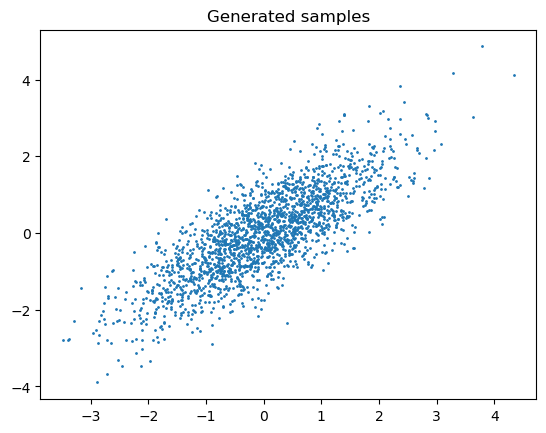

In [10]:
X_ = flow.sample(2000).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.title("Generated samples")
plt.show()

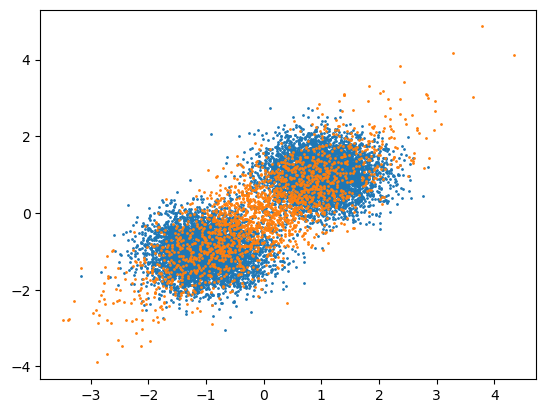

In [11]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

Definirani tok je prilično jednostavan stoga ne uspijeva dovoljno dobro aproksimirati $p_D$. Bolju performansu dobiti ćemo s kapacitetnijim tokom pod nazivom [RealNVP](https://arxiv.org/abs/1605.08803). RealNVP se sastoji od Coupling slojeva koji su invertibilni po konstrukciji.

Unaprijedni prolaz kroz afini coupling sloj s ulazom $\mathbf{x}$ dimenzionalnosti $d$ definiramo kao ($m < d$):
$$
\mathbf{z}_{:m} = \mathbf{x}_{:m}
$$
$$
\mathbf{z}_{m:d} = \exp(\ln\mathbf{s}) \odot \mathbf{x}_{m:d} + \mathbf{t}, \quad \ln s, t = net(\mathbf{x}_{:m})
$$

**Zadatak 4.**: Skicirajte računske grafove unaprijednog i unatražnog prolaza kroz afini coupling sloj. Zatim, nadopunite postojeći AffineCouplingLayer s prikladnom funkcionalnošću.

In [12]:
class AffineCouplingLayer(_Bijection):
    def __init__(self, net):
        super(AffineCouplingLayer, self).__init__()
        self.net = net
        self.m = net.dim

    def forward(self, x): # NxD
        y = torch.zeros_like(x)
        
        ln_s, t = self.net(x[:, :self.m])
        y[:, :self.m] = x[:, :self.m]
        y[:, self.m:] = x[:, self.m:] * torch.exp(ln_s) + t
        
        log_det = torch.sum(ln_s, axis=1)
        return y, log_det # NxD, N

    def inverse(self, y): # NxD
        x = torch.zeros_like(y)
        
        ln_s, t = self.net(y[:, :self.m])
        x[:, :self.m] = y[:, :self.m]
        x[:, self.m:] = (y[:, self.m:] - t) / torch.exp(ln_s)
        
        return x # NxD

class SwitchSides(_Bijection):

    def forward(self, x):
        x1, x2 = torch.chunk(x, dim=1, chunks=2)
        y = torch.cat((x2, x1), 1)
        return y, 0.

    def inverse(self, z):
        x1, x2 = torch.chunk(z, dim=1, chunks=2)
        x = torch.cat((x2, x1), 1)
        return x


class SimpleTransform(nn.Module):
    def __init__(self, dim, inflate_coef=2):
        super(SimpleTransform, self).__init__()
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        self.model = nn.Sequential(
            nn.Linear(dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, 2 * dim),
        )
        nn.init.zeros_(self.model[-1].weight)
        nn.init.zeros_(self.model[-1].bias)


    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t



class RealNVP(_NormalizingFlow):
    def __init__(self, input_dim, num_steps=2):
        super(RealNVP, self).__init__()
        self.transforms = nn.Sequential()
        for i in range(num_steps):
            self.transforms.append(AffineCouplingLayer(SimpleTransform(input_dim//2)))
            if i != num_steps - 1:
                self.transforms.append(SwitchSides())
        self.register_buffer('loc', torch.zeros(input_dim))
        self.register_buffer('log_scale', torch.zeros(input_dim))

    def z_dist(self):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        return z_dist

    def log_prob(self, x):
        z = x
        log_abs_det = 0.
        for m in self.transforms:
            z, ld_layer = m(z)
            log_abs_det += ld_layer
        log_pz = self.z_dist().log_prob(z).sum(-1)
        log_px =  + log_pz + log_abs_det
        return log_px

    
    def forward(self, x):
        z = x
        for m in self.transforms:
            z, _ = m(z)
        return z

    def inverse(self, z):
        for m in reversed(self.transforms):
            z = m.inverse(z)
        return z

    def sample(self, num_samples, T=1):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        z = z_dist.sample(torch.Size([num_samples])) * T
        x = self.inverse(z)
        return x


In [13]:
flow = RealNVP(2, num_steps=7)
optim = torch.optim.SGD(flow.parameters(), lr=1e-2, nesterov=True, momentum=0.9)

for iter in range(2000):
    optim.zero_grad()
    log_px = flow.log_prob(D)
    loss = - (log_px).mean()
    total_loss = loss
    total_loss.backward()
    optim.step()
    if iter % 20 == 0:
        print(f"Iter {iter+1}: Loss:{loss.item()}")

Iter 1: Loss:3.0862061977386475
Iter 21: Loss:2.7055883407592773
Iter 41: Loss:2.515117645263672
Iter 61: Loss:2.4818053245544434
Iter 81: Loss:2.4549899101257324
Iter 101: Loss:2.427509307861328
Iter 121: Loss:2.4022409915924072
Iter 141: Loss:2.3800837993621826
Iter 161: Loss:2.3606977462768555
Iter 181: Loss:2.34359073638916
Iter 201: Loss:2.328187942504883
Iter 221: Loss:2.3143653869628906
Iter 241: Loss:2.3021411895751953
Iter 261: Loss:2.2917439937591553
Iter 281: Loss:2.283289909362793
Iter 301: Loss:2.276231527328491
Iter 321: Loss:2.2697339057922363
Iter 341: Loss:2.2635178565979004
Iter 361: Loss:2.257354497909546
Iter 381: Loss:2.2506062984466553
Iter 401: Loss:2.243586301803589
Iter 421: Loss:2.2373569011688232
Iter 441: Loss:2.2323544025421143
Iter 461: Loss:2.228442907333374
Iter 481: Loss:2.225412368774414
Iter 501: Loss:2.2229807376861572
Iter 521: Loss:2.2209632396698
Iter 541: Loss:2.2191951274871826
Iter 561: Loss:2.217702865600586
Iter 581: Loss:2.216395139694214
It

In [14]:
print((flow.inverse(flow(D)) - D).sum())
assert (flow.inverse(flow(D)) - D).sum() < 1e-4

tensor(4.1014e-05, grad_fn=<SumBackward0>)


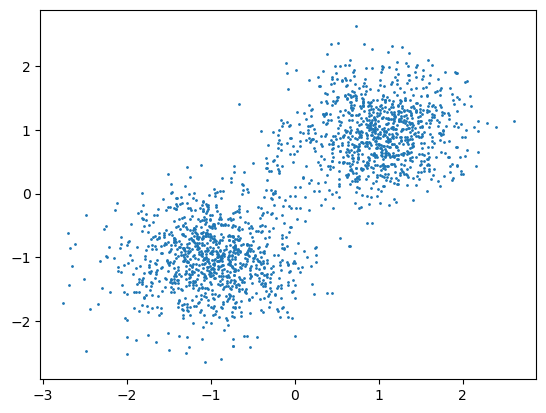

In [15]:
X_ = flow.sample(2000, 1).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

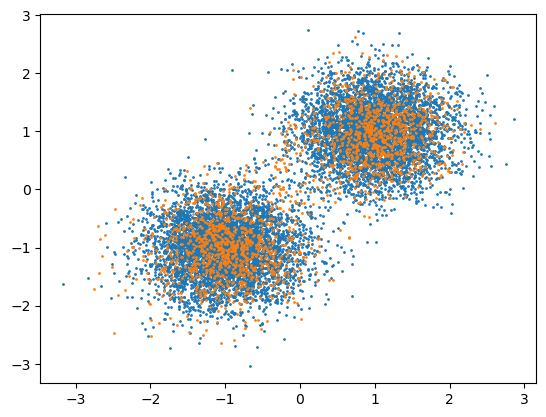

In [16]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)

Kao što vidite, kapacitetniji tok uspijeva dobro aproksimirati dani skup podataka.

## Modeliranje slika normalizirajućim tokom

Naš sljedeći zadatak je modelirati distribuciju slika s normalizirajućim tokom. Slike možemo prestaviti diskretnim tenzorom $\mathbf{x} \in [0, 255]^{C \times H \times W}$. Prisjetimo se da smo normalizirajući tok definirali za kontinuirane slučajne varijable. Stoga, potrebno je transfrormirati skup podataka u kontinuiranu domenu pomoću zašumljivanja:

$$
\mathbf{y} = \mathbf{x} + \mathbf{u}, \quad \mathbf{u} \sim \mathrm{U}[0, 1)
$$
U prestavlja uniformnu razdiobu. Sada, naš model uči modelirati zašumljenu sliku. Više o dekvantizaciji zašumljivanjem možete pronaći [ovdje](https://arxiv.org/pdf/1511.01844.pdf).

In [17]:
train_ds = MNIST('.', train=True, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()]))
test_ds = MNIST('.', train=False, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()])) 

selected_number = 0

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, train_ds[i][1]) for i in range(len(train_ds))]))]
train_ds = Subset(train_ds, indices)

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, test_ds[i][1]) for i in range(len(test_ds))]))]
test_ds = Subset(test_ds, indices)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

In [18]:
def plot_mnist(samples, num_row, num_col):
    assert len(samples) ==  num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(len(samples)):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(samples[i], cmap='gray')
    plt.tight_layout()
    plt.show()

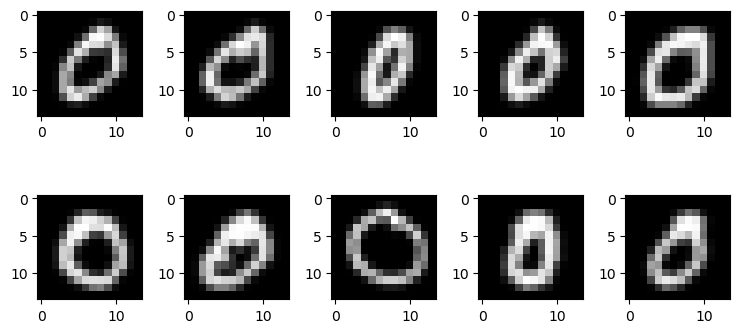

In [19]:
samples = [train_ds[i][0][0] for i in range(10)]
plot_mnist(samples, 2, 5)

In [20]:
class Squeeze2d(_Bijection):
    def __init__(self, factor=2):
        super().__init__()
        assert isinstance(factor, int)
        assert factor > 1
        self.factor = factor

    def _squeeze(self, x):
        assert len(x.shape) == 4, 'Dimension should be 4, but was {}'.format(len(x.shape))
        batch_size, c, h, w = x.shape
        assert h % self.factor == 0, 'h = {} not multiplicative of {}'.format(h, self.factor)
        assert w % self.factor == 0, 'w = {} not multiplicative of {}'.format(w, self.factor)
        t = x.view(batch_size, c, h // self.factor, self.factor, w // self.factor, self.factor)
        t = t.permute(0, 1, 3, 5, 2, 4).contiguous()

        z = t.view(batch_size, c * self.factor ** 2, h // self.factor, w // self.factor)
        return z

    def _unsqueeze(self, z):
        assert len(z.shape) == 4, 'Dimension should be 4, but was {}'.format(len(z.shape))
        batch_size, c, h, w = z.shape
        assert c % (self.factor ** 2) == 0, 'c = {} not multiplicative of {}'.format(c, self.factor ** 2)
        t = z.view(batch_size, c // self.factor ** 2, self.factor, self.factor, h, w)
        t = t.permute(0, 1, 4, 2, 5, 3).contiguous()
        x = t.view(batch_size, c // self.factor ** 2, h * self.factor, w * self.factor)
        return x

    def forward(self, x):
        z = self._squeeze(x)
        ldj = torch.zeros(x.shape[0], device=x.device, dtype=x.dtype)
        return z, ldj

    def inverse(self, z):
        x = self._unsqueeze(z)
        return x

**Zadatak 5.:** Nadopunite AffineCouplingLayer2d te oblikujte SimpleTransform2d s proizvoljnim transformacijama tako da normalizirajući tok može naučiti podskup MNIST slika. 


In [29]:
class AffineCouplingLayer2d(_Bijection):
    def __init__(self, net):
        #super(AffineCouplingLayer, self).__init__()
        super().__init__()
        self.net = net
        self.m = net.dim

    def forward(self, x): # NxCxHxW
        # Perform coupling across channels...
        # ...
        y = torch.zeros_like(x)
        
        ln_s, t = self.net(x[:, :self.m])
        y[:, :self.m] = x[:, :self.m]
        y[:, self.m:] = x[:, self.m:] * torch.exp(ln_s) + t
        
        log_det = torch.sum(ln_s, axis=(1, 2, 3))
        return y, log_det # NxCxHxW, N

    def inverse(self, y): # NxCxHxW
        x = torch.zeros_like(y)
        
        ln_s, t = self.net(y[:, :self.m])
        x[:, :self.m] = y[:, :self.m]
        x[:, self.m:] = (y[:, self.m:] - t) / torch.exp(ln_s)
        
        return x # NxCxHxW
        
class SimpleTransform2d(nn.Module):
    def __init__(self, dim, inflate_coef=2, bn=True):
        super(SimpleTransform2d, self).__init__()
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        if bn:
            self.model = nn.Sequential(
                nn.Conv2d(dim, internal_dim, kernel_size=1),
                # umetnite slojeve ovdje
                nn.Conv2d(internal_dim, internal_dim*2, kernel_size=3, padding='same', bias=False),
                nn.BatchNorm2d(internal_dim*2),
                nn.ReLU(),
                nn.Conv2d(internal_dim*2, internal_dim*4, kernel_size=3, padding='same', bias=False),
                nn.BatchNorm2d(internal_dim*4),
                nn.ReLU(),
                nn.Conv2d(internal_dim*4, internal_dim*8, kernel_size=3, padding='same', bias=False),
                nn.BatchNorm2d(internal_dim*8),
                nn.ReLU(),
                #############
                nn.Conv2d(internal_dim*8, 2 * dim, kernel_size=1),
            )
        else:
            self.model = nn.Sequential(
                nn.Conv2d(dim, internal_dim, kernel_size=1),
                # umetnite slojeve ovdje
                nn.Conv2d(internal_dim, internal_dim*2, kernel_size=3, padding='same'),
                nn.ReLU(),
                nn.Conv2d(internal_dim*2, internal_dim*4, kernel_size=3, padding='same'),
                nn.ReLU(),
                nn.Conv2d(internal_dim*4, internal_dim*8, kernel_size=3, padding='same'),
                nn.ReLU(),
                #############
                nn.Conv2d(internal_dim*8, 2 * dim, kernel_size=1),
            )
        nn.init.zeros_(self.model[-1].weight)
        nn.init.zeros_(self.model[-1].bias)

    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t

class RealNVPMNIST(_NormalizingFlow):
    def __init__(self, channels, image_shape, num_steps=2, blocks=2, bn=True):
        super(RealNVPMNIST, self).__init__()
        num_dims = image_shape[0] * image_shape[1] * channels
        self.transforms = nn.Sequential()

        for _ in range(blocks):
            self.transforms.append(Squeeze2d())
            channels = channels * 4
            image_shape = (image_shape[0] // 2, image_shape[1] // 2) 
            for i in range(num_steps):
                self.transforms.append(AffineCouplingLayer2d(SimpleTransform2d(channels//2, bn=bn)))
                if i != num_steps-1:
                    self.transforms.append(SwitchSides())

        self.register_buffer('loc', torch.zeros(num_dims))
        self.register_buffer('log_scale', torch.zeros(num_dims))
        self.channels = channels
        self.image_shape = image_shape

    def z_dist(self):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        return z_dist

    def log_prob(self, x):
        z = x
        log_abs_det = 0.
        for m in self.transforms:
            z, ld_layer = m(z)
            log_abs_det += ld_layer
        
        z = z.view(z.shape[0], -1)
        log_pz = sum_except_batch(self.z_dist().log_prob(z))
        log_px =  + log_pz + log_abs_det
        return log_px

    
    def forward(self, x):
        z = x
        for m in self.transforms:
            z, _ = m(z)
        return z

    def inverse(self, z):
        for m in reversed(self.transforms):
            z = m.inverse(z)
        return z

    def sample(self, num_samples, T=1):
        z_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))
        z = z_dist.sample(torch.Size([num_samples])) * T
        z = z.reshape(num_samples, self.channels ,*self.image_shape)
        x = self.inverse(z)
        return x


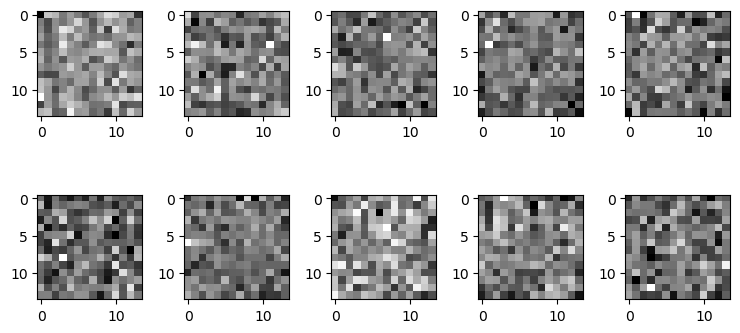

Epoch 1: Train Loss:1231.5224297706118 Val BPD: 8.719583511352539


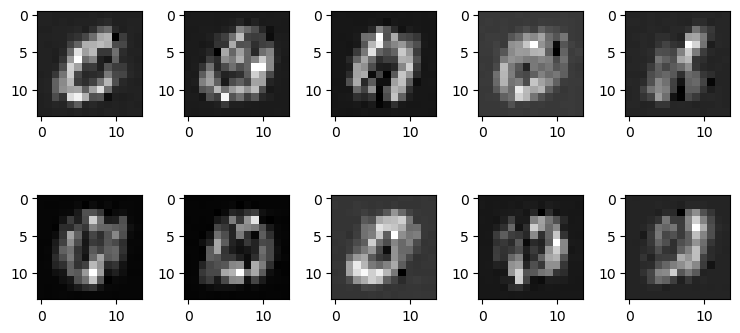

Epoch 11: Train Loss:554.7904741003158 Val BPD: 4.103015899658203


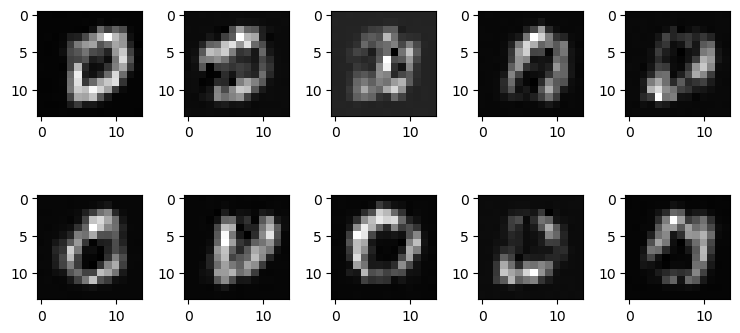

Epoch 21: Train Loss:486.3587951660156 Val BPD: 3.6057260036468506


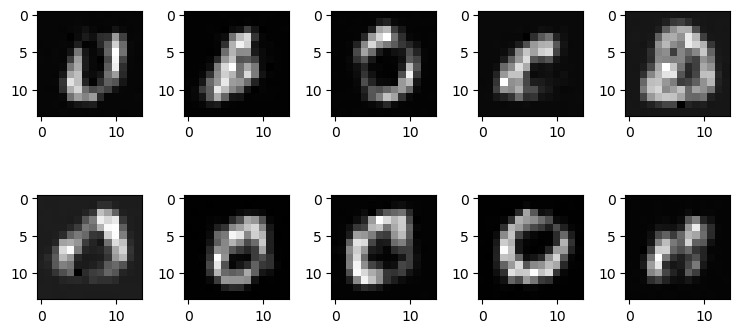

Epoch 31: Train Loss:448.8974869099069 Val BPD: 3.357912302017212


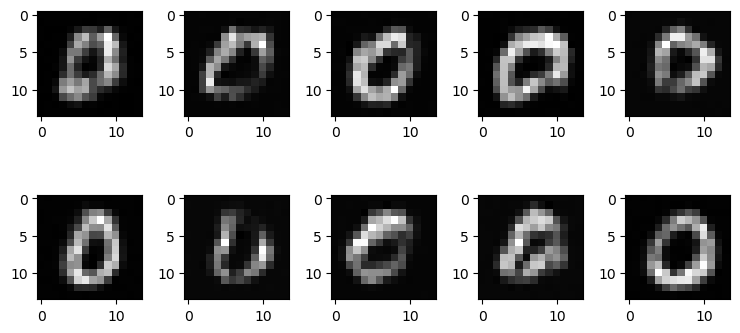

Epoch 41: Train Loss:428.4175720214844 Val BPD: 3.2236623764038086


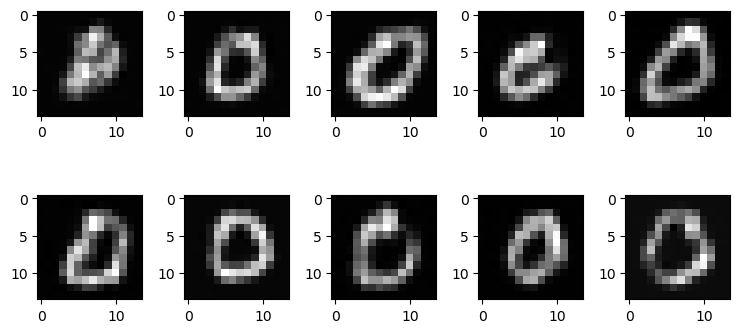

Epoch 51: Train Loss:416.01525294527096 Val BPD: 3.139216184616089


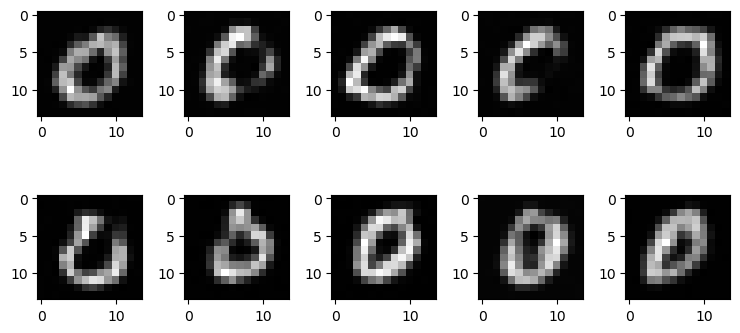

Epoch 61: Train Loss:406.7810727383228 Val BPD: 3.0866994857788086


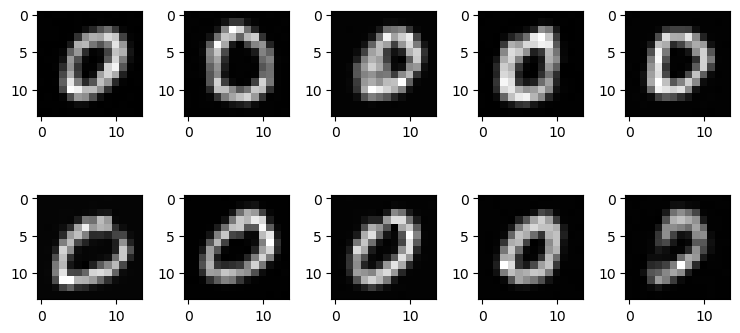

Epoch 71: Train Loss:401.4916518191074 Val BPD: 3.0485575199127197


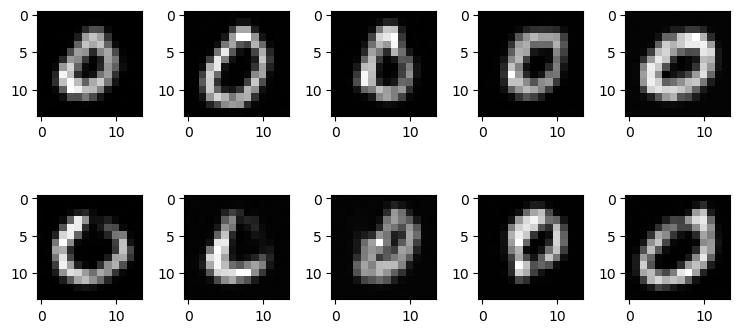

Epoch 81: Train Loss:395.5437368839345 Val BPD: 3.0207138061523438


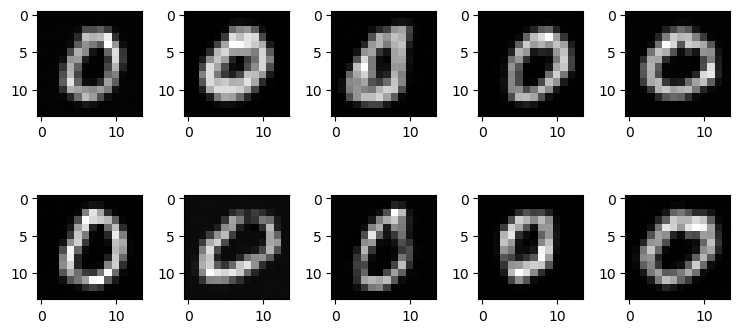

Epoch 91: Train Loss:392.63808684653424 Val BPD: 2.993389844894409


In [30]:
device = 'cuda'
image_shape = (14, 14)
flow = RealNVPMNIST(1, image_shape, num_steps=15, blocks=1).to(device)
optim = torch.optim.AdamW(flow.parameters(), lr=1e-4)
epochs = 100
bits = 8
for ep in range(epochs):
    total_loss = 0.
    iters = 0
    for x, _ in train_loader:
        x = (x * 255).long()
        u = torch.rand_like(x.float())
        y = x + u
        y = y / (2 ** bits)
        
        optim.zero_grad()
        log_py = flow.log_prob(y.to(device)) - np.log((2 ** bits)) * (image_shape[0] * image_shape[1])
        loss = - (log_py).mean()
        loss.backward()
        optim.step()
        iters += 1
        total_loss += loss.item()
    if ep % 10 == 0:
        with torch.no_grad():
            val_iters = 0
            total_bpd = 0.
            for x, _ in test_loader:
                x = (x * 255).long()
                u = torch.rand_like(x.float())
                y = x + u
                y = y / (2 ** bits)
                log_px = flow.log_prob(y.to(device)) - np.log((2 ** bits)) * (image_shape[0] * image_shape[1])
                bpd = -(log_px).mean().cpu() / (np.log(2) * (image_shape[0] * image_shape[1]))
                total_bpd += bpd
                val_iters += 1
        samples = flow.sample(10).detach().cpu()
        plot_mnist(samples[:, 0], 2, 5)

        print(f"Epoch {ep+1}: Train Loss:{total_loss / iters} Val BPD: {total_bpd / val_iters}")

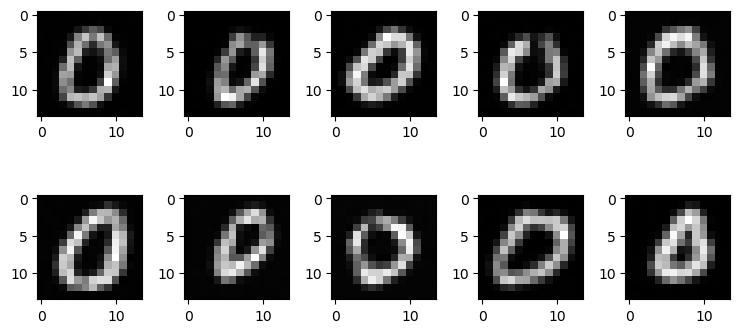

In [31]:
samples = flow.sample(10).detach().cpu()
plot_mnist(samples[:,0], 2, 5)

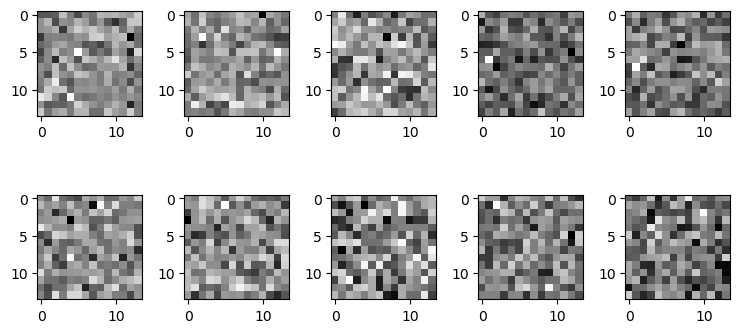

Epoch 1: Train Loss:1268.2279676072142 Val BPD: 9.216642379760742


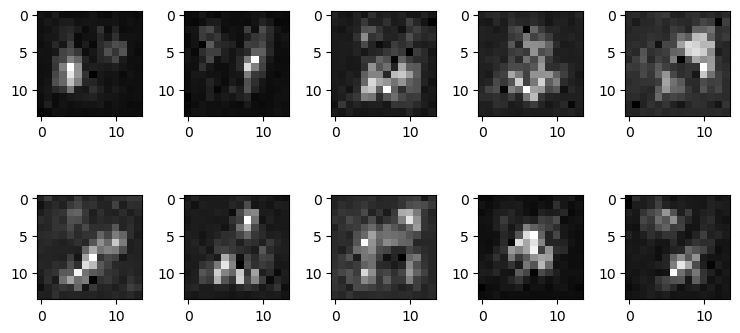

Epoch 11: Train Loss:787.6583667511636 Val BPD: 5.670678615570068


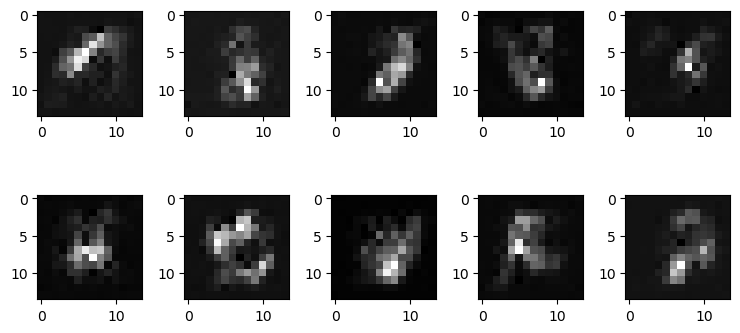

Epoch 21: Train Loss:625.4564520653258 Val BPD: 4.560850620269775


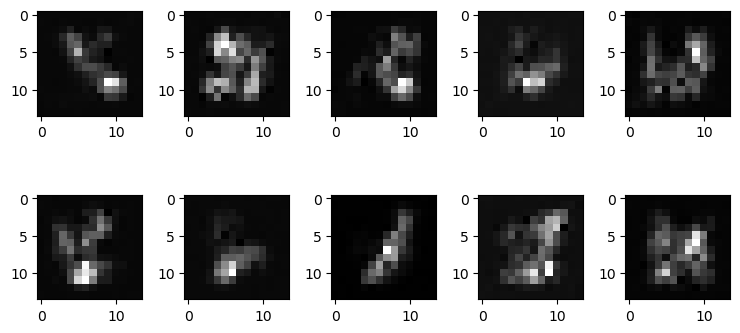

Epoch 31: Train Loss:569.5839064577792 Val BPD: 4.163470268249512


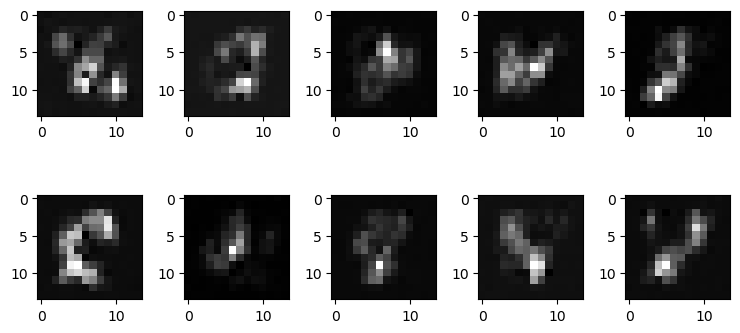

Epoch 41: Train Loss:536.9373117000499 Val BPD: 3.9296932220458984


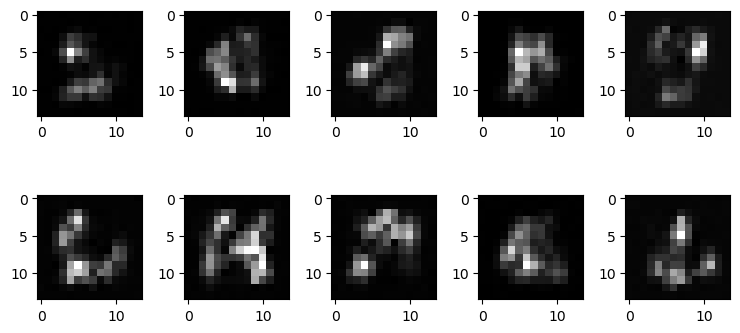

Epoch 51: Train Loss:511.9076843261719 Val BPD: 3.7434892654418945


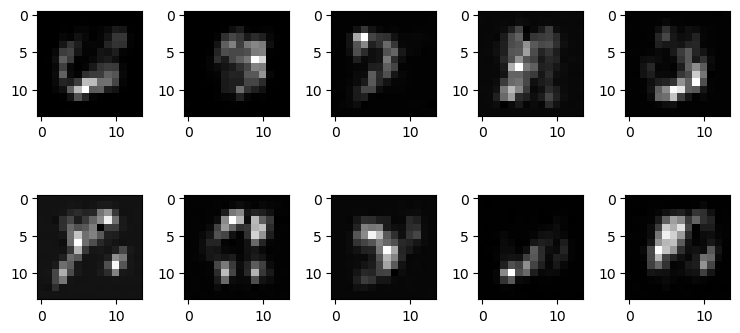

Epoch 61: Train Loss:493.9543898562168 Val BPD: 3.6116042137145996


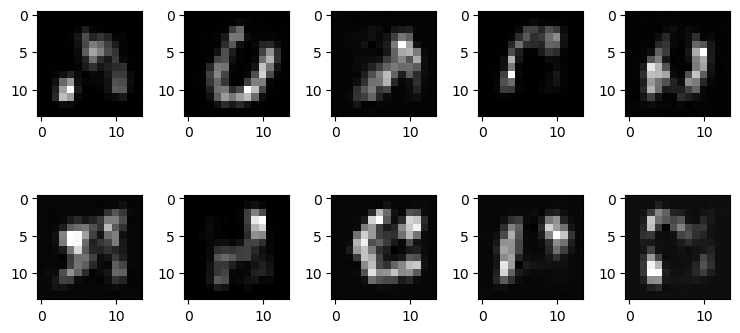

Epoch 71: Train Loss:480.05574977144283 Val BPD: 3.5143980979919434


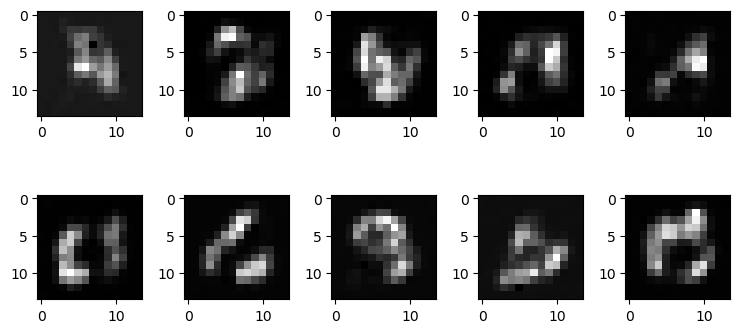

Epoch 81: Train Loss:469.2828317195811 Val BPD: 3.4455959796905518


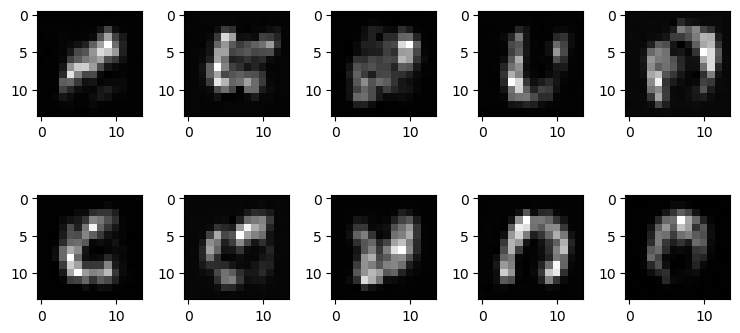

Epoch 91: Train Loss:459.88028863135804 Val BPD: 3.3684184551239014


In [32]:
device = 'cuda'
image_shape = (14, 14)
flow = RealNVPMNIST(1, image_shape, num_steps=15, blocks=1, bn=False).to(device)
optim = torch.optim.AdamW(flow.parameters(), lr=1e-4)
epochs = 100
bits = 8
for ep in range(epochs):
    total_loss = 0.
    iters = 0
    for x, _ in train_loader:
        x = (x * 255).long()
        u = torch.rand_like(x.float())
        y = x + u
        y = y / (2 ** bits)
        
        optim.zero_grad()
        log_py = flow.log_prob(y.to(device)) - np.log((2 ** bits)) * (image_shape[0] * image_shape[1])
        loss = - (log_py).mean()
        loss.backward()
        optim.step()
        iters += 1
        total_loss += loss.item()
    if ep % 10 == 0:
        with torch.no_grad():
            val_iters = 0
            total_bpd = 0.
            for x, _ in test_loader:
                x = (x * 255).long()
                u = torch.rand_like(x.float())
                y = x + u
                y = y / (2 ** bits)
                log_px = flow.log_prob(y.to(device)) - np.log((2 ** bits)) * (image_shape[0] * image_shape[1])
                bpd = -(log_px).mean().cpu() / (np.log(2) * (image_shape[0] * image_shape[1]))
                total_bpd += bpd
                val_iters += 1
        samples = flow.sample(10).detach().cpu()
        plot_mnist(samples[:, 0], 2, 5)

        print(f"Epoch {ep+1}: Train Loss:{total_loss / iters} Val BPD: {total_bpd / val_iters}")

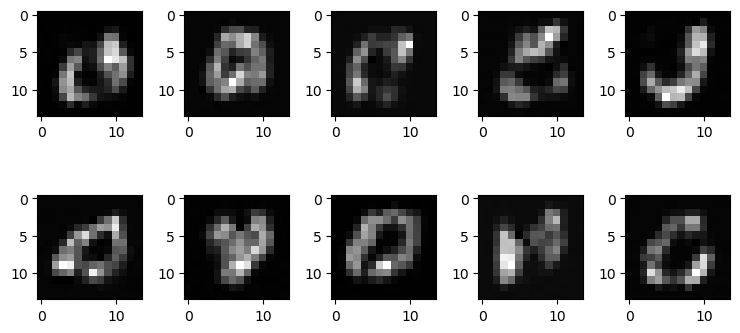

In [33]:
samples = flow.sample(10).detach().cpu()
plot_mnist(samples[:,0], 2, 5)

Pitanja:
1. Objasnite koje ste sve slojeve koristili pri dizajnu SimpleTransform2d.

- Conv2d - provodi operaciju konvolucije nad slikom
- BatchNorm2d - provodi normalizaciju po grupi, koristi se prije relu aktivacije
- ReLU - aktivacijska funkcija čija je formula $f(x) = max(0, x)$

2. Što se dogodi ako u SimpleTransform2d uključite BatchNorm?

- Rezultati su lošiji i konvergencija je sporija